# Temperature Profile
This looks at the temperature and MSE profiles on days with different `convflag` values.

In [2]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p
from isca_tools.utils import area_weighting, annual_mean
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.aquaplanet_theory import get_delta_temp_quant_theory, get_gamma
from isca_tools.convection.simple_betts_miller import lcl_temp, ref_temp_above_lcl, get_temp_ref
from isca_tools.convection import dry_profile_pressure, moist_profile
from isca_tools.plot import label_subplots
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import interpolate
import matplotlib.animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import numpy_indexed
from scipy.stats import percentileofscore
import copy
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

2024-01-30 11:34:18,715 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [3]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height', 'klzbs', 'convflag', 't_ref', 'ps', 'tdt_rad', 'dt_tg_convection', 
            'dt_tg_condensation', 'dt_tg_diffusion']        # only keep variables required to compute relative humidity
# Load dataset
tau_lw_ref = 1
exp_dir = 'aquaplanet/temp_tendency/'
exp_names = [f"k={str(tau_lw_ref).replace('.','_')}", "k=1_5"]
n_exp = len(exp_names)
ds_base = []
albedo = []
tau_sw = []
tau_lw = []

use_time_start = 360*2
for i in range(n_exp):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])
    try:
        ds_use = ds_use[var_keep]
    except KeyError:
        remove_keys = []
        for key in var_keep:
            if key not in ds_use:
                print(f'Removing {key} from var_keep')
                remove_keys += [key]
        for key in remove_keys:
            var_keep.remove(key)
        ds_use = ds_use[var_keep]
    ds_base += [ds_use.sel(time=slice(use_time_start, np.inf))]      # only keep after spin up
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]

## Get datasets
Get one surface dataset for summer for each $\kappa$, combining all latitudes: `ds_all`. This combines the summer months in each hemisphere, e.g. negative latitudes will only correspond to times in December, January or February.

Also get an equivalent dataset consisting of free troposphere rather than surface values: `ds_all_ft`.

In [4]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

### Temperature Profiles for Different Convective Days

In [85]:
lat_use = 46     # approximate latitude to use

lzb_thresh_deep = 12     # Need klzb to be lower than this so LZB is less than 560hPa (14) or 413hPa (12)
lzb_thresh_shallow = 14
convflag_thresh_deep = 1.8       # Need more than this to be considered deep convection
convflag_thresh_shallow = 0.8

ds = {'all': [], 'deep': [], 'shallow': [], 'none': []}  # need dataset for each convective option
with tqdm(total=n_exp, position=0, leave=True) as pbar:
    for i in range(n_exp):
        ds_use = ds_base[i].sel(lat=lat_use, method='nearest')
        ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
        ds['all'] += [ds_use.load()]
        keep_deep = np.logical_and(ds_use.klzbs<lzb_thresh_deep, ds_use.convflag > convflag_thresh_deep)
        keep_shallow = np.logical_and(ds_use.klzbs<lzb_thresh_shallow, ds_use.convflag > convflag_thresh_shallow)
        keep_shallow = np.logical_and(keep_shallow, np.invert(keep_deep))       # make sure shallow does not include deep conv days
        keep_none = np.invert(np.logical_or(keep_deep, keep_shallow))           # no convection is all those that are not deep or shallow
        ds['deep'] += [ds_use.where(keep_deep).load()]
        ds['shallow'] += [ds_use.where(keep_shallow).load()]
        ds['none'] += [ds_use.where(keep_none).load()]
        pbar.update(1)
p_surface = float(ds['all'][0].pfull[-1])
lat_actual = float(ds['all'][0].lat)

100%|██████████| 2/2 [00:33<00:00, 16.79s/it]


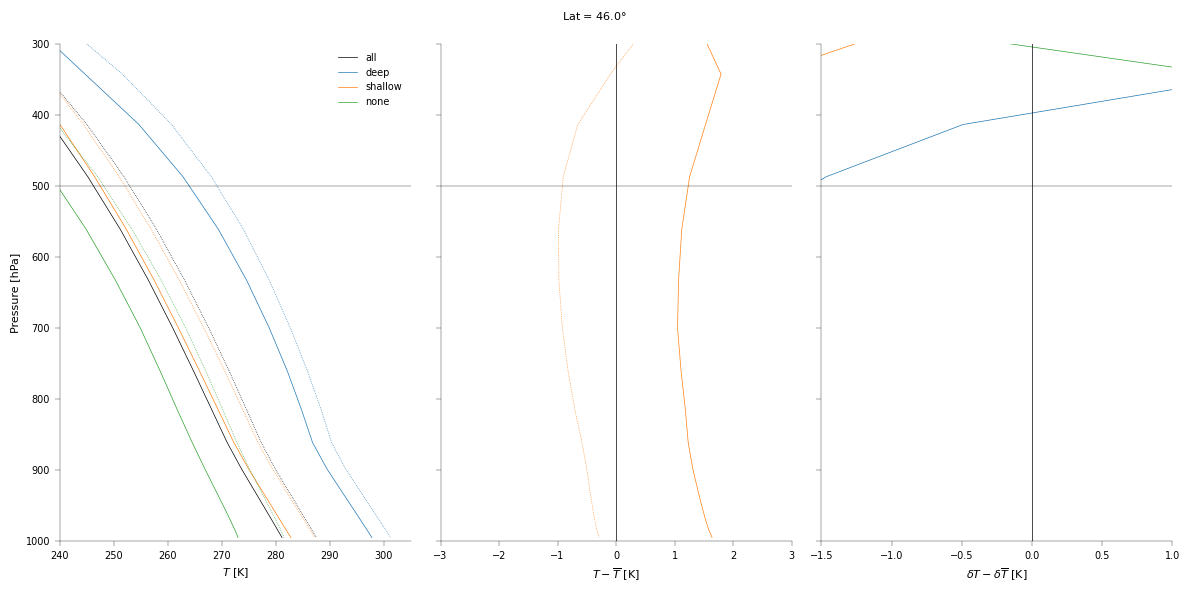

In [86]:
fig, ax = plt.subplots(1, 3, figsize=(12,6), sharey=True)
for i, key in enumerate(ds):
    use_color = 'k' if i==0 else default_colors[i-1]
    ax[0].plot(ds[key][0].temp.mean(dim='lon_time'), ds[key][0].pfull, color=use_color, label=key)
    ax[0].plot(ds[key][1].temp.mean(dim='lon_time'), ds[key][0].pfull, color=use_color, linestyle=':')
    if key != 'all':
        ax[1].plot(ds[key][0].temp.mean(dim='lon_time') - ds['all'][0].temp.mean(dim='lon_time'), ds[key][0].pfull, color=use_color)
        ax[1].plot(ds[key][1].temp.mean(dim='lon_time') - ds['all'][1].temp.mean(dim='lon_time'), ds[key][0].pfull, color=use_color,
                   linestyle=':')
        ax[2].plot((ds[key][1].temp.mean(dim='lon_time') - ds[key][0].temp.mean(dim='lon_time')) - (ds['all'][1].temp.mean(dim='lon_time') - ds['all'][0].temp.mean(dim='lon_time')), ds[key][0].pfull, color=use_color)
ax[0].legend()
ax[0].hlines(500, 0, 1000, color='k', lw=ax_linewidth)
ax[1].hlines(500, -10, 1000, color='k', lw=ax_linewidth)
ax[2].hlines(500, -10, 1000, color='k', lw=ax_linewidth)
ax[1].vlines(0, -10, 1000, color='k')
ax[2].vlines(0, -10, 1000, color='k')
ax[0].set_ylim(300, 1000)
ax[1].set_xlim(-3, 3)
ax[2].set_xlim(-1.5, 1)
ax[0].invert_yaxis()
ax[0].set_xlim(240, 305)
ax[0].set_ylabel('Pressure [hPa]')
ax[0].set_xlabel('$T$ [K]')
ax[1].set_xlabel('$T - \overline{T}$ [K]')
ax[2].set_xlabel('$\delta T - \delta \overline{T}$ [K]')
fig.suptitle(f'Lat = {round(lat_actual, 1)}$\degree$', fontsize=8)
plt.tight_layout()

### MSE Profiles for Different Convective Days

In [87]:
mse_ft_sat = {key: np.asarray([moist_static_energy(ds[key][i].temp, sphum_sat(ds[key][i].temp, ds[key][i].pfull*100), 
                                                  ds[key][i].height).mean(dim='lon_time') 
                              for i in range(n_exp)]) for key in ds}
mse_ft_sat_ref = {key: np.asarray([moist_static_energy(ds[key][i].t_ref, sphum_sat(ds[key][i].t_ref, ds[key][i].pfull*100), 
                                                  ds[key][i].height).mean(dim='lon_time') 
                                   for i in range(n_exp)]) for key in ds}
mse_surf = {key: np.asarray([moist_static_energy(ds[key][i].temp[-1], ds[key][i].sphum[-1], 
                                                 ds[key][i].height[-1]).mean(dim='lon_time')  
                             for i in range(n_exp)]) for key in ds}

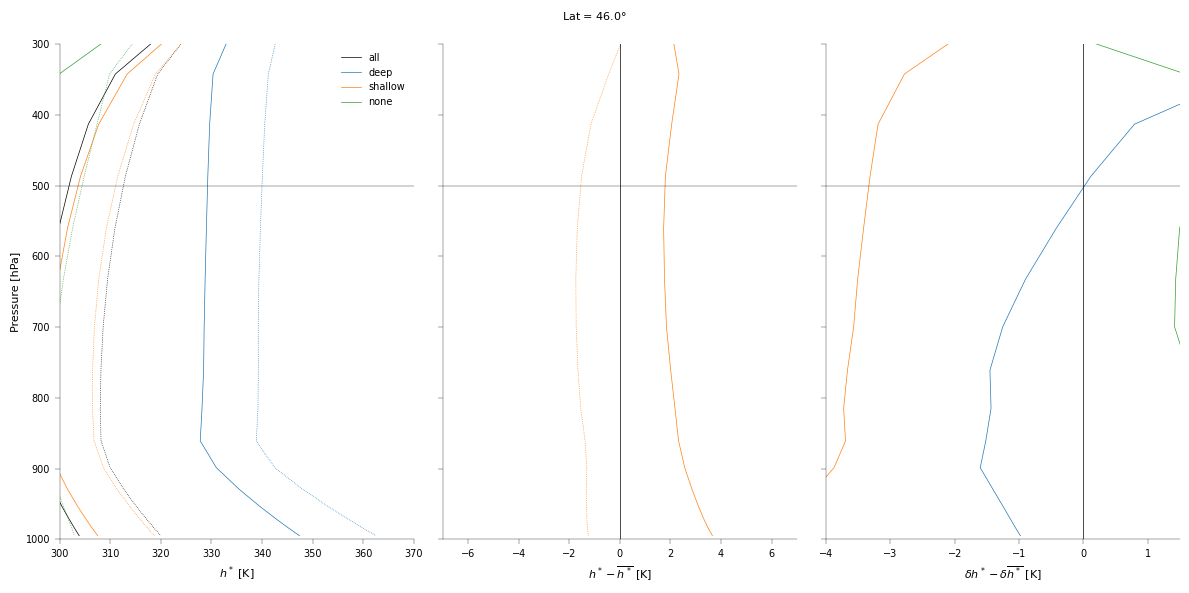

In [88]:
fig, ax = plt.subplots(1, 3, figsize=(12,6), sharey=True)
for i, key in enumerate(ds):
    use_color = 'k' if i==0 else default_colors[i-1]
    for j in range(n_exp):
        linestyle_use = '-' if j==0 else ':'
        ax[0].plot(mse_ft_sat[key][j]*1000/c_p, ds[key][j].pfull, color=use_color, linestyle=linestyle_use, label=key if j==0 else None)
        if key != 'all':
            ax[1].plot((mse_ft_sat[key][j] - mse_ft_sat['all'][j])*1000/c_p, ds[key][0].pfull, color=use_color,
                       linestyle=linestyle_use)
            if j == 0:
                ax[2].plot((mse_ft_sat[key][1] - mse_ft_sat[key][0])*1000/c_p - (mse_ft_sat['all'][1] - mse_ft_sat['all'][0])*1000/c_p,
                           ds[key][0].pfull, color=use_color, linestyle=linestyle_use)
ax[0].legend()
ax[0].hlines(500, 0, 1000, color='k', lw=ax_linewidth)
ax[1].hlines(500, -10, 1000, color='k', lw=ax_linewidth)
ax[2].hlines(500, -10, 1000, color='k', lw=ax_linewidth)
ax[1].vlines(0, -10, 1000, color='k')
ax[2].vlines(0, -10, 1000, color='k')
ax[1].set_xlim(-7, 7)
ax[2].set_xlim(-4, 1.5)
ax[0].set_ylim(300, 1000)
ax[0].invert_yaxis()
ax[0].set_xlim(300, 370)
ax[0].set_ylabel('Pressure [hPa]')
ax[0].set_xlabel('$h^*$ [K]')
ax[1].set_xlabel('$h^* - \overline{h^*}$ [K]')
ax[2].set_xlabel('$\delta h^* - \delta \overline{h^*}$ [K]')
fig.suptitle(f'Lat = {round(lat_actual, 1)}$\degree$', fontsize=8)
plt.tight_layout();

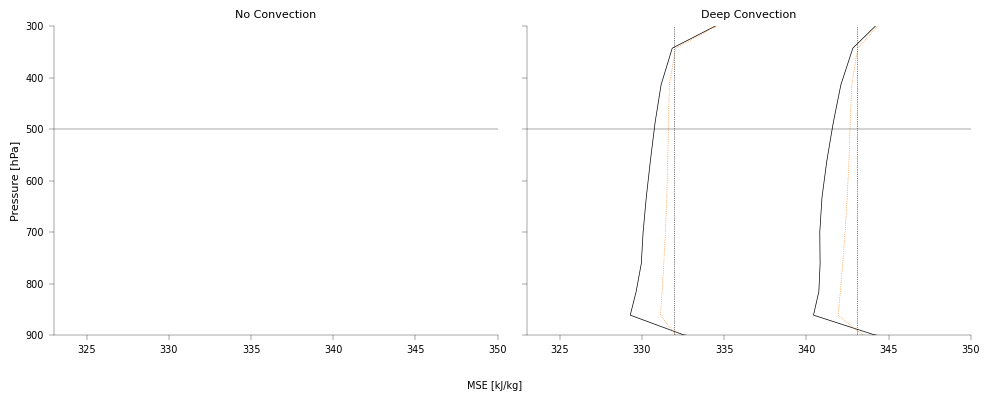

In [89]:
fig, ax = plt.subplots(1, 2, figsize=(10,4), sharey=True, sharex=True)
for i, key in enumerate(['none', 'deep']):
    for j in range(n_exp):
        ax[i].plot(mse_ft_sat[key][j], ds[key][0].pfull, color='k')
        ax[i].plot(mse_ft_sat_ref[key][j], ds[key][0].pfull, color=default_colors[1], linestyle=':')
        ax[i].vlines(mse_surf[key][j], 0, 1000, color='k', linestyle=':')
    ax[i].hlines(500, 0, 1000, color='k', lw=ax_linewidth)
ax[0].invert_yaxis()
ax[0].set_xlim(323, 350)
ax[0].set_ylim(900, 300)
fig.supxlabel('MSE [kJ/kg]', fontsize=7)
ax[0].set_ylabel('Pressure [hPa]')
ax[0].set_title('No Convection')
ax[1].set_title('Deep Convection')
plt.tight_layout()

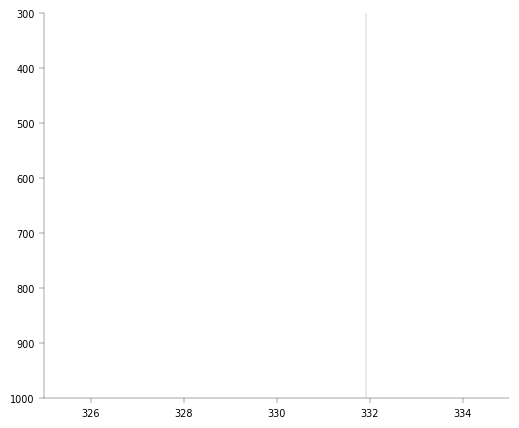

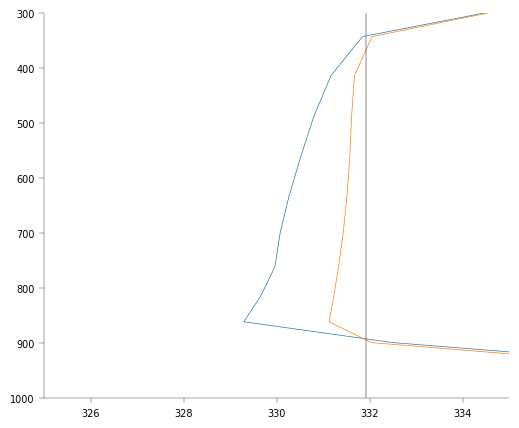

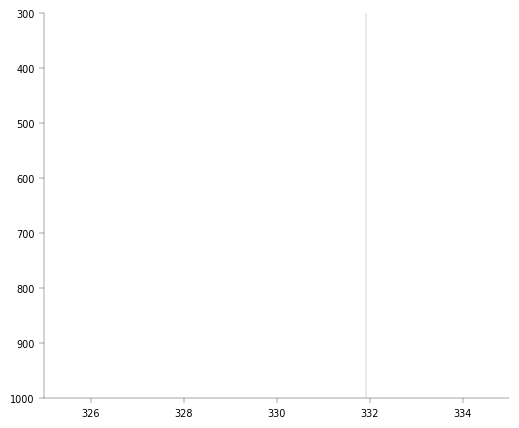

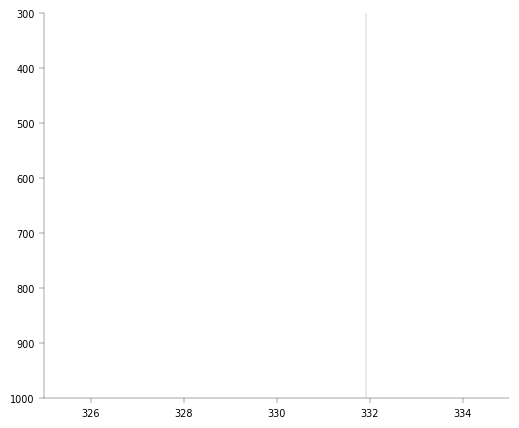

In [90]:
for key in ds:
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    ax.plot(mse_ft_sat[key][0], ds[key][0].pfull)
    ax.plot(mse_ft_sat_ref[key][0], ds[key][0].pfull)
    ax.vlines(mse_surf[key][0], 0, 1000, color='k', lw=ax_linewidth)
    ax.vlines(mse_surf['deep'][0], 0, 1000, color='grey', lw=ax_linewidth)
    ax.invert_yaxis()
    ax.set_xlim(325, 335)
    ax.set_ylim(1000, 300)

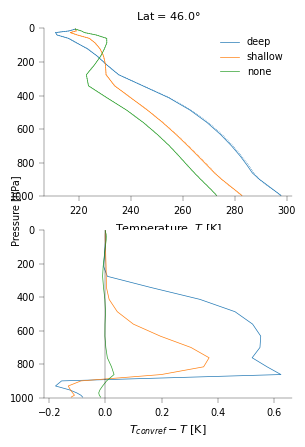

In [96]:
save_conv_profile_fig = False
fig, ax = plt.subplots(2, 1, figsize=(width['one_col'], 2*(width['one_col']/ar)), sharey=True)
for i, key in enumerate(['deep', 'shallow', 'none']):
    ax[0].plot(ds[key][0].temp.mean(dim='lon_time'), ds[key][0].pfull, color=default_colors[i], label=key)
    ax[0].plot(ds[key][0].t_ref.mean(dim='lon_time'), ds[key][0].pfull, color=default_colors[i], linestyle=':')
    ax[1].plot(ds[key][0].t_ref.mean(dim='lon_time') - ds[key][0].temp.mean(dim='lon_time'), ds[key][0].pfull, 
               color=default_colors[i], label=key)
ax[1].vlines(0, 0, 1000, color='k', lw=ax_linewidth)
ax[0].legend()
ax[0].invert_yaxis()
ax[0].set_ylim(1000, 0)
ax[0].set_xlabel('Temperature, $T$ [K]')
ax[1].set_xlabel('$T_{conv ref} - T$ [K]')
fig.supylabel('Pressure [hPa]', fontsize=7)
ax[0].set_title(f'Lat = {round(lat_actual, 1)}$\degree$', fontsize=8)
if save_fig or save_conv_profile_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/temp_conv_profile.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

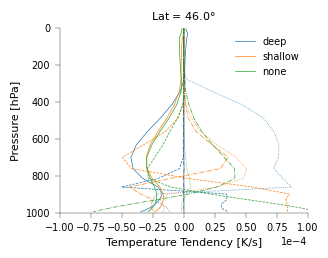

In [98]:
save_temp_tendency_fig = False
fig, ax = plt.subplots(1, 1, figsize=(width['one_col'], width['one_col']/ar))
for i, key in enumerate(['deep', 'shallow', 'none']):
    ax.plot(ds[key][0].tdt_rad.mean(dim='lon_time'), ds[key][0].pfull, color=default_colors[i], label=key)
    ax.plot(ds[key][0].dt_tg_convection.mean(dim='lon_time'), ds[key][0].pfull, color=default_colors[i], linestyle=':')
    ax.plot(ds[key][0].dt_tg_diffusion.mean(dim='lon_time'), ds[key][0].pfull, color=default_colors[i], linestyle='--')
    ax.plot(ds[key][0].dt_tg_condensation.mean(dim='lon_time'), ds[key][0].pfull, color=default_colors[i], linestyle='-.')
    # ax.plot((ds[key][0].dt_tg_condensation+ds[key][0].dt_tg_diffusion+ds[key][0].dt_tg_convection+ds[key][0].tdt_rad).mean(dim='lon_time'), ds[key][0].pfull, color=default_colors[i], linestyle='-')
ax.legend()
ax.invert_yaxis()
ax.set_ylim(1000, 0)
ax.set_xlabel('Temperature Tendency [K/s]')
ax.set_ylabel('Pressure [hPa]')
ax.set_title(f'Lat = {round(lat_actual, 1)}$\degree$', fontsize=8)
ax.vlines(0, 0, 1000, color='k', lw=ax_linewidth)
ax.set_xlim(-10e-5, 10e-5)
ax.ticklabel_format(style='sci',scilimits=(-3,4),axis='x')
if save_fig or save_temp_tendency_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/temp_tendency.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)